In [15]:
import nltk
import pandas as pd 
import spacy
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
import re 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from IPython.display import display
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/raheen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/raheen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.2 MB/s eta 0:00:0000:0100:01



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [16]:
read= pd.read_csv('fake_job_posting/fake_job_postings.csv')
print(read.to_string)

<bound method DataFrame.to_string of        job_id                                              title  \
0           1                                   Marketing Intern   
1           2          Customer Service - Cloud Video Production   
2           3            Commissioning Machinery Assistant (CMA)   
3           4                  Account Executive - Washington DC   
4           5                                Bill Review Manager   
...       ...                                                ...   
17875   17876                   Account Director - Distribution    
17876   17877                                 Payroll Accountant   
17877   17878  Project Cost Control Staff Engineer - Cost Con...   
17878   17879                                   Graphic Designer   
17879   17880                         Web Application Developers   

                   location   department salary_range  \
0          US, NY, New York    Marketing          NaN   
1            NZ, , Auckland     

In [17]:
read= pd.read_csv('fake_job_posting/fake_job_postings.csv')
print(pd.options.display.max_rows) 

60


In [20]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.lower()                # Lowercase the text
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/numbers
    tokens = word_tokenize(text)       # Tokenize
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    text = ' '.join(tokens)            # Join back to string
    doc = nlp(text)                    # spaCy processing
    lemmatized_tokens = [token.lemma_ for token in doc]  # Lemmatize
    return ' '.join(lemmatized_tokens)


In [24]:
read['job_text'] = (
    read['title'].fillna('') + ' ' +
    read['company_profile'].fillna('') + ' ' +
    read['description'].fillna('') + ' ' +
    read['requirements'].fillna('') + ' ' +
    read['benefits'].fillna('')
)
print("Preprocessing all job postings...")
read['cleaned_job_text'] = read['job_text'].apply(preprocess_text)
print("Preprocessing complete!")
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

display(read.head())  # Shows all columns with full cleaned text


Preprocessing all job postings...
Preprocessing complete!


job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range  \
0  Marketing          NaN   
1    Success          NaN   
2        NaN          NaN   
3      Sales          NaN   
4        NaN          NaN   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                company_profile  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City.   
1                                                                                                    

In [25]:
from sklearn.model_selection import train_test_split

X = read['cleaned_job_text']
y = read['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       0.99      0.43      0.60       173

    accuracy                           0.97      3576
   macro avg       0.98      0.71      0.79      3576
weighted avg       0.97      0.97      0.97      3576

[[3402    1]
 [  99   74]]


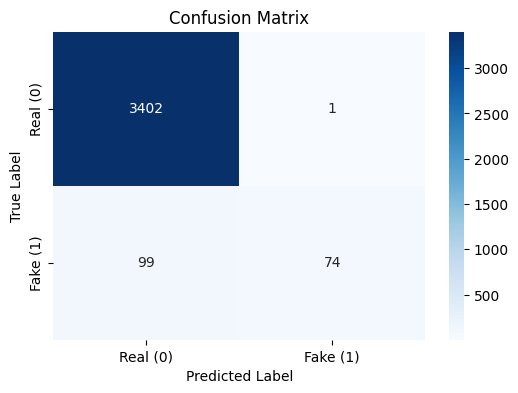

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(X_test_tfidf)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real (0)', 'Fake (1)'], yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [35]:
def verify_company(name):
    if pd.isna(name) or str(name).strip() == "":
        return "Unknown"
    company_keywords = ["Inc", "Ltd", "LLC", "Corporation", "GmbH", "Pvt"]
    if any(word.lower() in name.lower() for word in company_keywords):
        return "Likely Real"
    return "Suspicious"

def salary_status(salary):
    if pd.isna(salary) or str(salary).strip() == "":
        return "Unknown"
    salary_str = str(salary).lower()
    if any(word in salary_str for word in ["per hour", "per week", "per month"]):
        return "Normal"
    if "$" in salary_str and any(int(num) > 200000 for num in re.findall(r'\d+', salary_str)):
        return "Too Good to be True"
    return "Normal"

def scam_score(text):
    scam_words = ["wire transfer", "bitcoin", "western union", "urgent hiring", 
                  "no experience needed", "fast money", "work from home"]
    score = sum(1 for word in scam_words if word in text.lower())
    return round(score * 1.64, 2)  # scaled score

def scam_keywords_found(text):
    scam_words = ["wire transfer", "bitcoin", "western union", "urgent hiring", 
                  "no experience needed", "fast money", "work from home"]
    found = [word for word in scam_words if word in text.lower()]
    return ", ".join(found) if found else None


In [36]:
read['company_status'] = read['company_profile'].apply(verify_company)
read['salary_status'] = read['salary_range'].apply(salary_status)
read['scam_score'] = read['job_text'].apply(scam_score)
read['scam_keywords_found'] = read['job_text'].apply(scam_keywords_found)


In [37]:
from sklearn.preprocessing import LabelEncoder

le_company = LabelEncoder()
le_salary = LabelEncoder()

read['company_status_encoded'] = le_company.fit_transform(read['company_status'])
read['salary_status_encoded'] = le_salary.fit_transform(read['salary_status'])


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(read['cleaned_job_text'])

# Numeric features
X_numeric = read[['scam_score', 'company_status_encoded', 'salary_status_encoded']].values

# Combine text + numeric features
X_final = hstack([X_text, X_numeric])
y = read['fraudulent']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       0.97      0.45      0.62       173

    accuracy                           0.97      3576
   macro avg       0.97      0.73      0.80      3576
weighted avg       0.97      0.97      0.97      3576



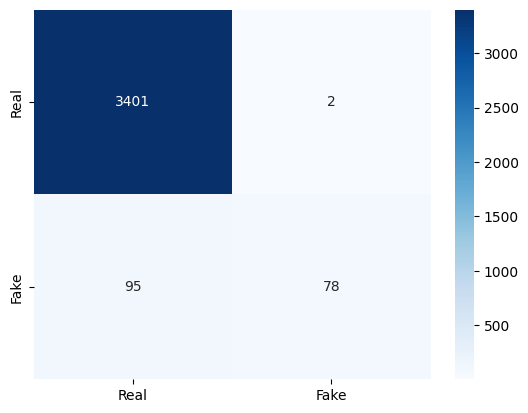

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# 1️⃣ Convert cleaned text to numeric vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(read['cleaned_job_text'])

# 2️⃣ Convert numeric scam-related features to array
X_numeric = read[['scam_score', 'company_status_encoded', 'salary_status_encoded']].values

# 3️⃣ Combine text + numeric features
X_final = hstack([X_text, X_numeric])

# 4️⃣ Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, read['fraudulent'], test_size=0.2, random_state=42, stratify=read['fraudulent']
)

# 5️⃣ Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# 6️⃣ Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.show()
